# Vine-copula model for VaR estimation
Copulas separate the marginal distributions from the dependency structure in a given multivariate distribution. This allows to model the entire multivariate distribution even when only a parametric form for the marginals is defined as well as to model dependence structures outside of the gaussian one. This notebook applies the copula modeling to a multivariate time series of stock prices. The prices are considered in log term and first difference. The stocks considered are JP Morgan, Coca Cola, Apple, Amazon, Microsoft, Google, and Tesla. The dependence structure is firstly estimated using the Gaussian copula and so through the inversion of the Sklaar's theorem. In a second section the assumption of Gaussian copula is relaxed and a vine-structure is fit. Finally, it is proposed a Stationary bootstrapping Vine-copula model to estimate the risk associated such a portfolio.

In [454]:
# Import packages
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import kendalltau, norm
from scipy.linalg import cholesky
import math
import random
import arch
import seaborn as sns
from vinecopulas.marginals import *
from vinecopulas.vinecopula import *

# List of tickers considered
tickers = ["JPM", "KO", "AAPL", "AMZN", "MSFT", "GOOGL", "TSLA"]

# Download the stock data for the tickers
stocks = yf.download(tickers, period="max")
data = stocks["Adj Close"]
data = data.dropna()

# Logerithm of the percentage change (+1).
data_pct_chg = np.log(data.pct_change() + 1).iloc[1:]

[*********************100%***********************]  7 of 7 completed


The upper graphs plots the evolution of the multivariate time series from june 2010 until October 2024. The second graph plots the evolution of the log values in first difference. Here, each value $\delta p_t$ is the equivalent of:
$$
\delta p_t := \log(p_t) - \log(p_{t-1}) = \log\left(\frac{p_t}{p_{t-1}}\right) = \log\left(\frac{p_t - p_{t-1}}{p_{t-1}} + 1\right)
$$
With $\frac{p_t - p_{t-1}}{p_{t-1}}$ being the percentage variation of $p_t$ with respect to $p_{t-1}$.

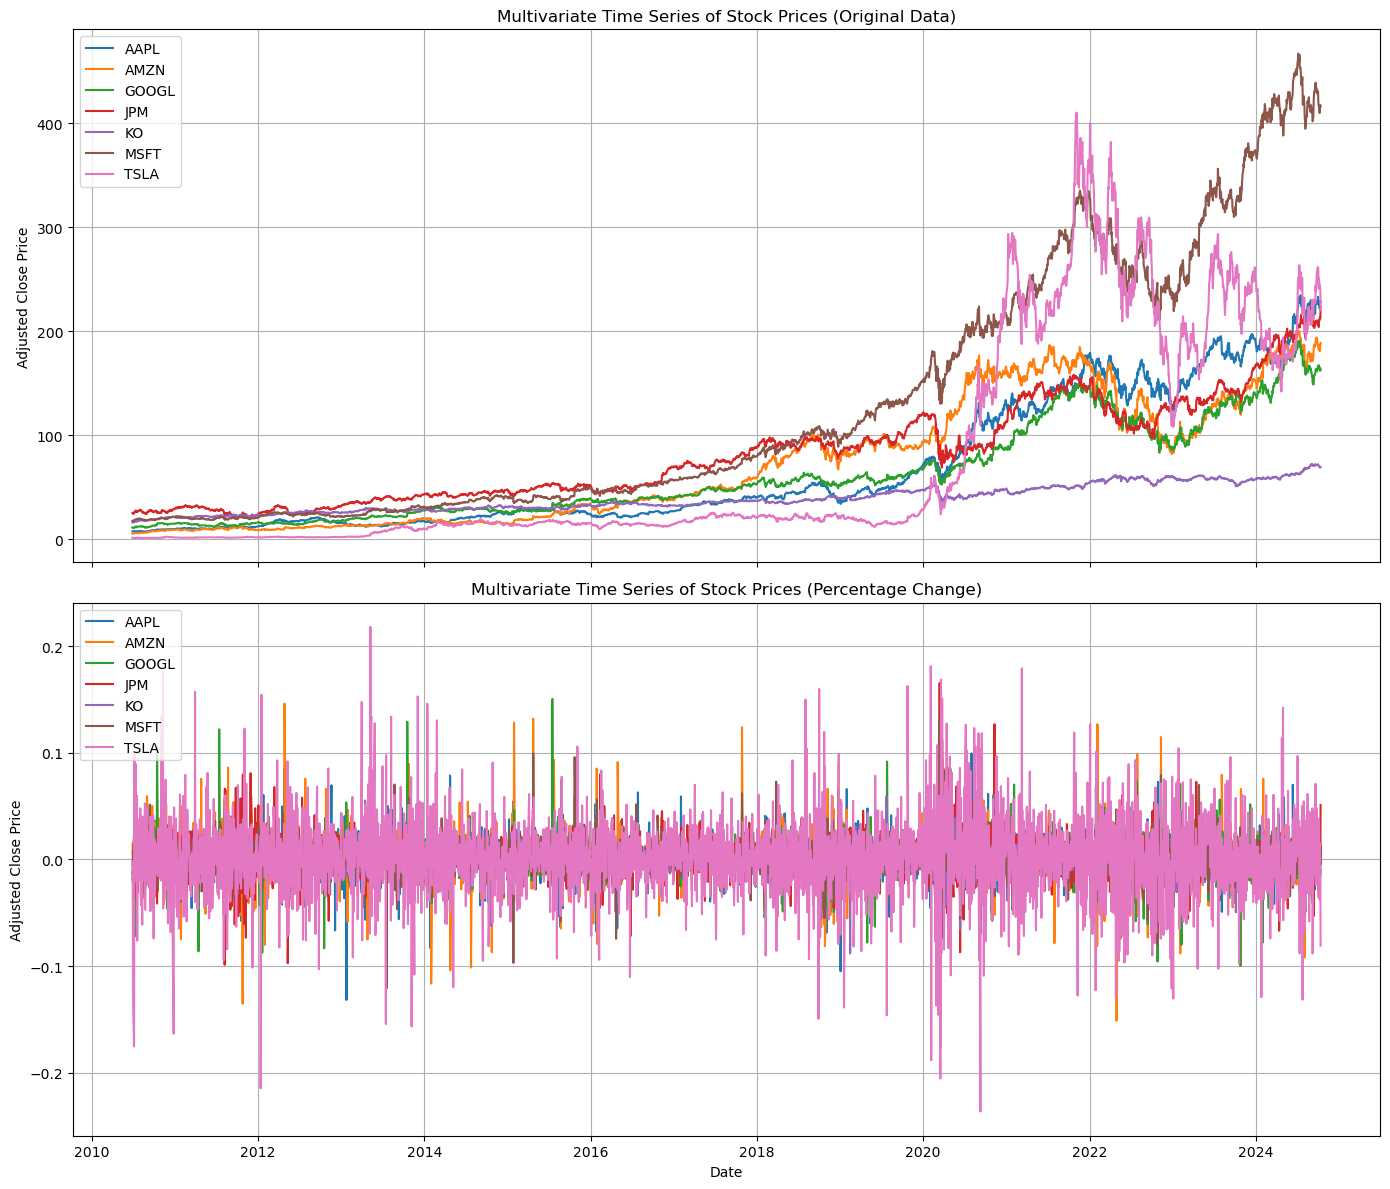

In [456]:
import matplotlib.pyplot as plt

# Create a unified plot with two subplots (one for each dataset)
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# First subplot: Original 'data'
for ticker in data.columns:
    axs[0].plot(data.index, data[ticker], label=ticker)
axs[0].set_title('Multivariate Time Series of Stock Prices (Original Data)')
axs[0].set_ylabel('Adjusted Close Price')
axs[0].legend(loc="upper left")
axs[0].grid(True)

# Second subplot: 'data_pct_chg'
for ticker in data_pct_chg.columns:
    axs[1].plot(data_pct_chg.index, data_pct_chg[ticker], label=ticker)
axs[1].set_title('Multivariate Time Series of Stock Prices (Log-Percentage Change)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Adjusted Close Price')
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Gaussian copula
The dependence structure is initially assumed to be lienar. Hence, the different marginals will be glued together through the Gaussian copula. The following matrix of graphs plots in the main diagonals the ranked marginals over the unit interval, while the other garphs plot the scatter of the pseudo-data of each pair. To have more readable graphs, only the last 1.000 observations are plotted.

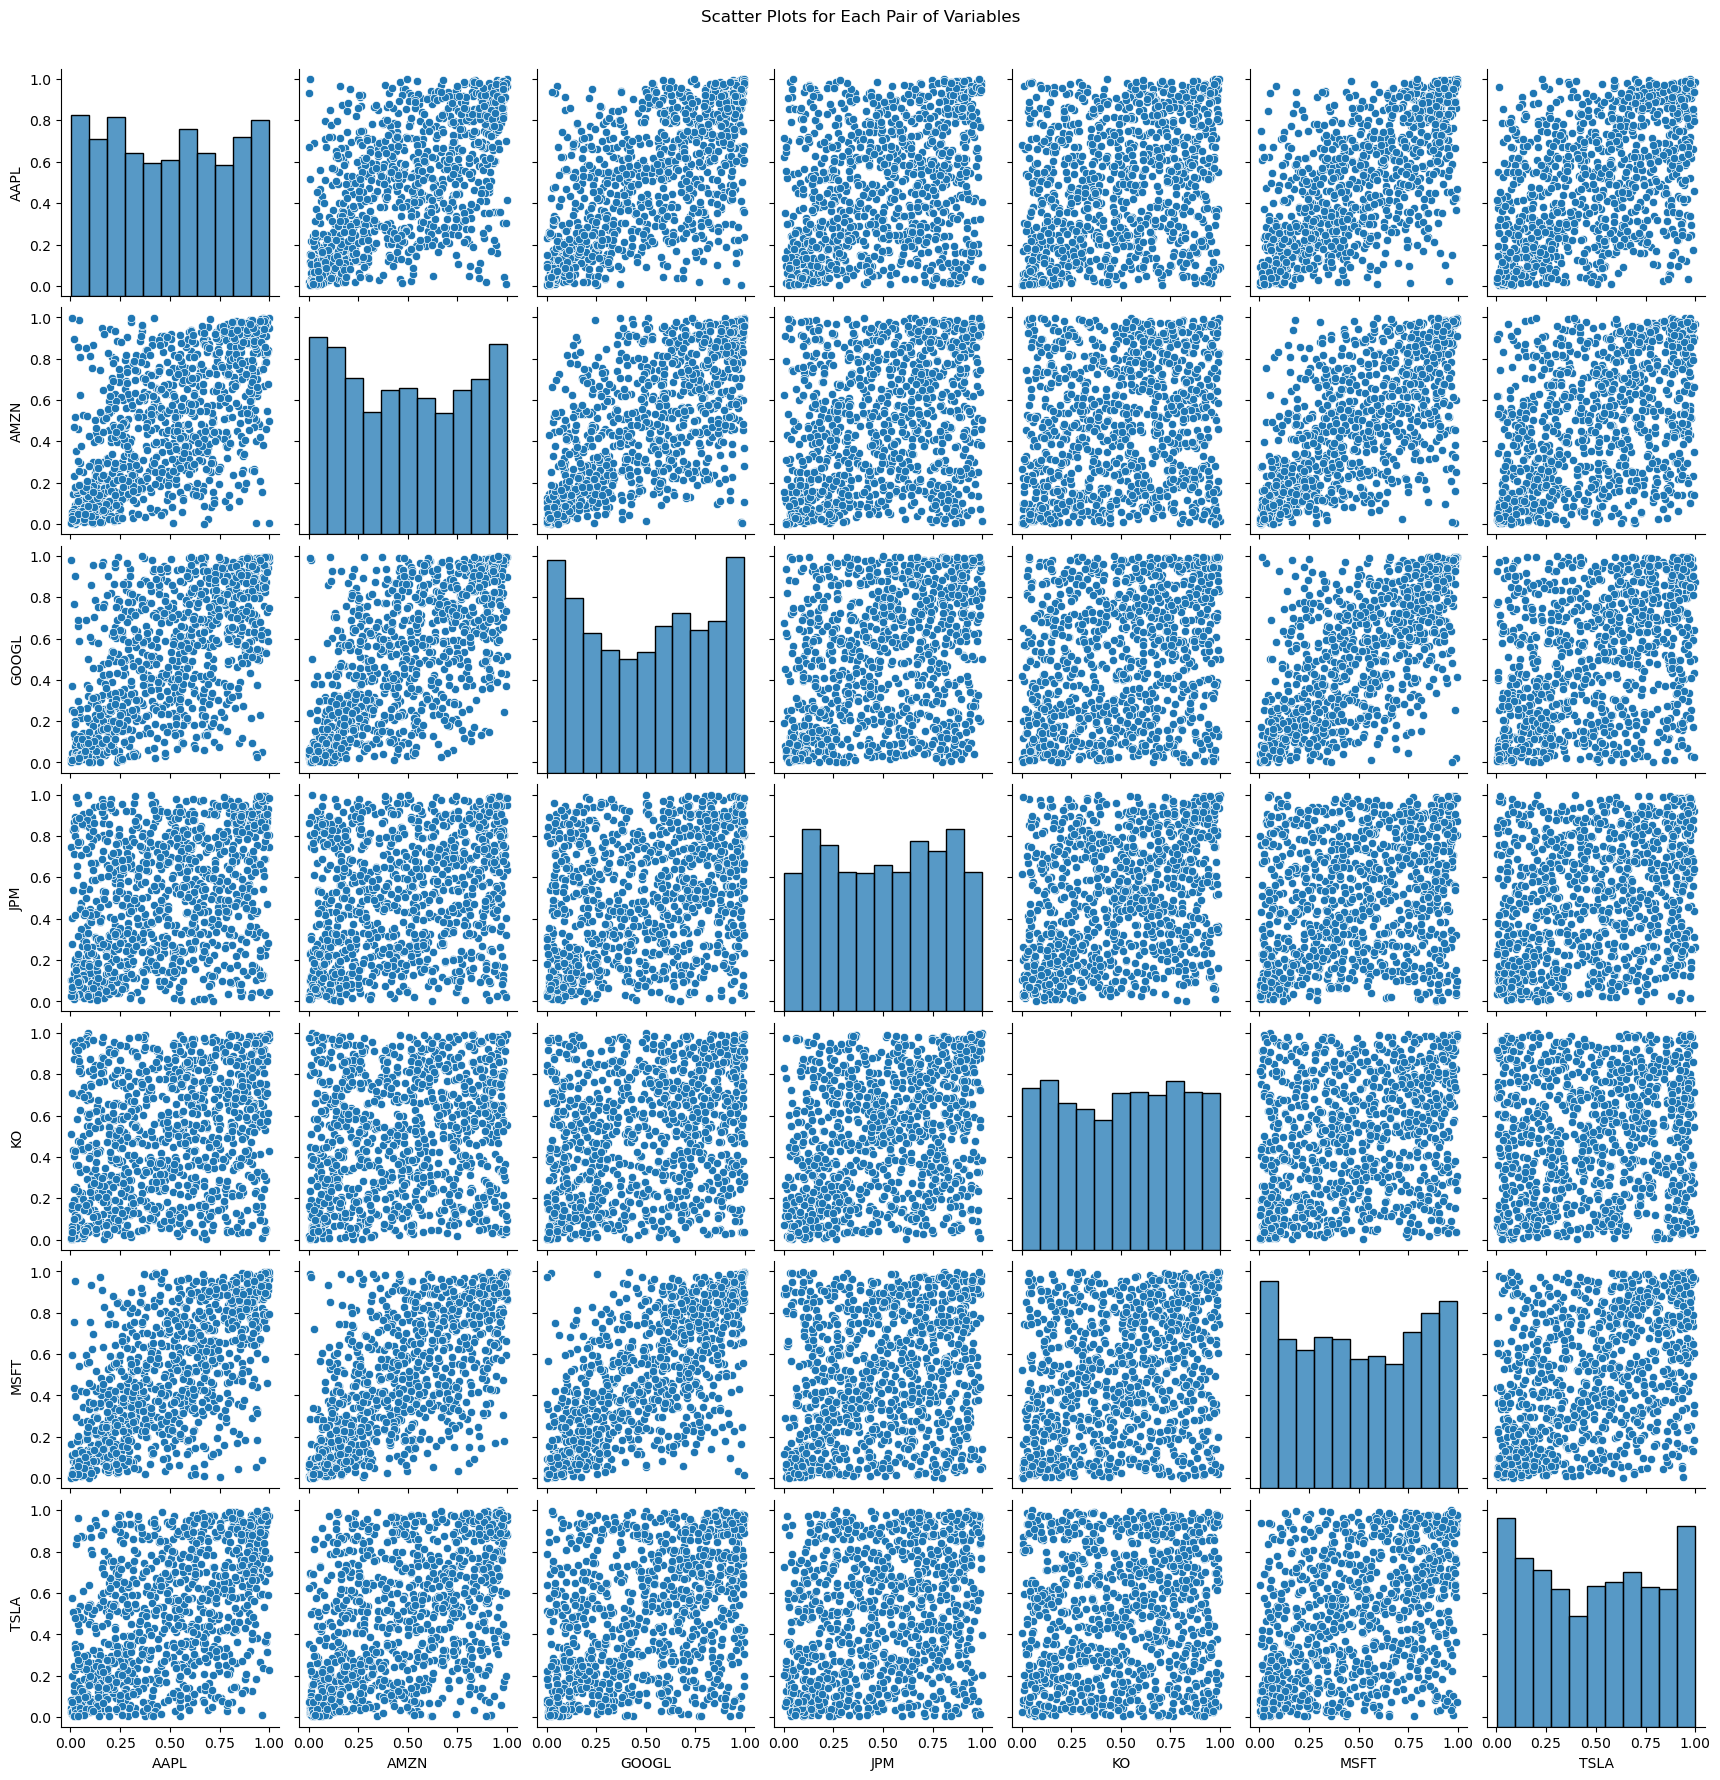

In [577]:
data_ranked = (data_pct_chg.rank()/(len(data_pct_chg) + 1))
sns.pairplot(data_ranked.tail(1000))
plt.suptitle("Scatter Plots for Each Pair of Variables", y=1.02)
plt.show()

To derive the gaussian copula, the rank correlation matrix is computed in which each element of the matrix is the Kendall's tau of the corresponding marginals.

In [459]:
# Rank Correlation matrix (Kendall's Tau)
n = data_ranked.shape[1]
rank_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        if i == j:
            rank_matrix[i, j] = 1.0  # The values in the main diagonal have rank correlation equal to 1.
        else:
            tau, _ = kendalltau(data_ranked.iloc[:, i], data_ranked.iloc[:, j])
            rank_matrix[i, j] = tau # The matrix is symmetric
            rank_matrix[j, i] = tau

rank_matrix = pd.DataFrame(rank_matrix, columns=data_ranked.columns, index=data_ranked.columns)
rank_matrix

Ticker,AAPL,AMZN,GOOGL,JPM,KO,MSFT,TSLA
Ticker,,,,,,,
AAPL,1.000000,0.352859,0.388426,0.240204,0.177526,0.394213,0.253017
AMZN,0.352859,1.000000,0.464863,0.224588,0.167502,0.415104,0.265708
GOOGL,0.388426,0.464863,1.000000,0.275525,0.218248,0.463922,0.246031
JPM,0.240204,0.224588,0.275525,1.000000,0.241145,0.274623,0.169399
KO,0.177526,0.167502,0.218248,0.241145,1.000000,0.240996,0.110220
MSFT,0.394213,0.415104,0.463922,0.274623,0.240996,1.000000,0.242876
TSLA,0.253017,0.265708,0.246031,0.169399,0.110220,0.242876,1.000000


From the Kendall's tau it is possible to derive the covariances of the variance-covariance matrix of the normal CDF to be inverted because of Sklaar's theorem. Here, each $ij$ element of the variance-covariance matrix will be:
$$
\rho_{ij} = \sin(\tau_{ij} \frac{\pi}{2})
$$

In short, we are now interested in the multivariate normal distribution:

$$
\Phi_5(\hat{\mu}, \Sigma)
$$

With $\Sigma = [\rho_{ij}]$ and $\hat{\mu}$ being the column-wise mean of the ranked data. Hence, inverting Sklaar's theorem one gets:
$$
C_{gauss} = \Phi_5(\Phi^{-1}(u_1),...,\Phi^{-1}(u_d))
$$

To sample from the gaussian copula (being a function from $[0,1]^d \mapsto [0,1]$ the values sampled are in the interval $[0,1]$), it is possible to exploit the cholesky decomposition so that the following algorithm is implemented:

1) Sample $d$ independent random variables standard normal: $Z\sim N(0;1)$.
2) Change the covariance matrix premultiplying the vector $Z$ by the cholesky decomposition of the variance covariance matrix: $X = \Sigma^{1/2}Z$.
3) Apply the standard normal quantile function to the vector of observations obtained.
4) iterate this process for the number of samples desired.

Once sample from the copula, each vector extracted will contain the quantiles of the corresponding marginals.

In [461]:
Sigma = np.sin(rank_matrix * np.pi / 2)

# Function to perform the steps
def sample_from_gaussian_copula(Sigma, n_samples):
    L = cholesky(Sigma, lower=True)
    d = Sigma.shape[0]
    Z = np.random.normal(size=(n_samples, d))
    X = np.dot(Z, L.T)
    U = norm.cdf(X)
    return U

simulations = sample_from_gaussian_copula(Sigma, n_samples=1000)
simulated_observations_log_pct_change = pd.DataFrame(np.percentile(data_pct_chg, 100 * simulations))
simulated_observations_log_pct_change.columns = data_pct_chg.columns
actual_obs_simulated = np.exp(simulated_observations_log_pct_change).cumprod()

In the following pair of graphs, the upper one plots the evolution of the simulated $\delta p_t$ term and the second one plots the evolution of the $p_t$ term. 

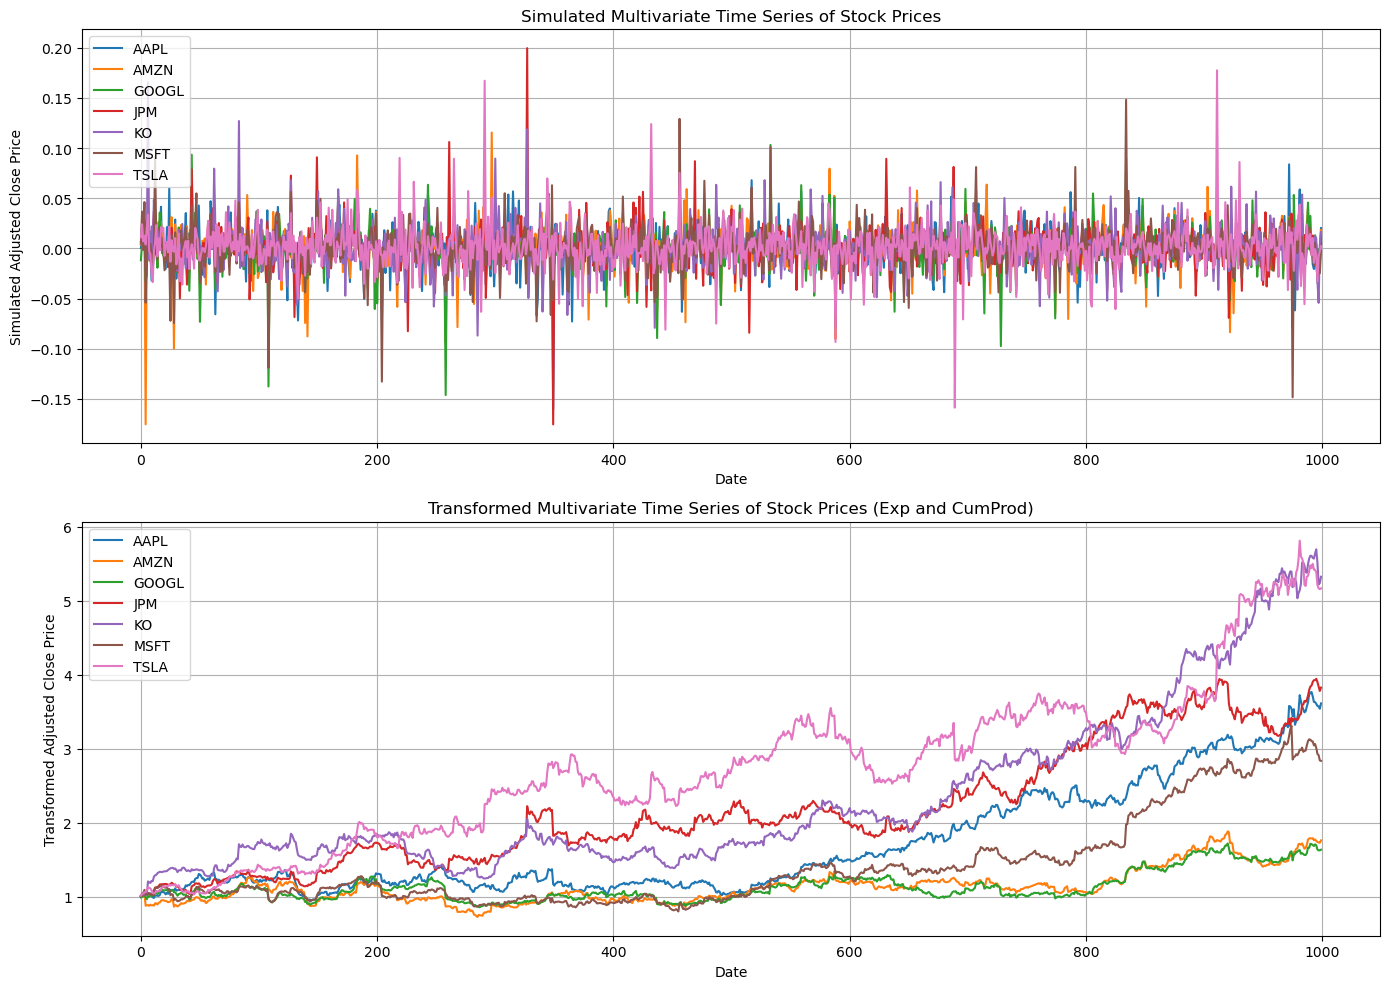

In [462]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
for ticker in simulated_observations_log_pct_change.columns:
    plt.plot(simulated_observations_log_pct_change.index, simulated_observations_log_pct_change[ticker], label=ticker)
plt.title('Simulated Multivariate Time Series of Stock Prices (Log-percentage change)')
plt.xlabel('Date')
plt.ylabel('Simulated Adjusted Close Price')
plt.legend(loc="upper left")
plt.grid(True)

plt.subplot(2, 1, 2)
for ticker in actual_obs_simulated.columns:
    plt.plot(actual_obs_simulated.index, actual_obs_simulated[ticker], label=ticker)
plt.title('Simulated Multivariate Time Series of Stock Prices (in actual terms)')
plt.xlabel('Date')
plt.ylabel('Transformed Adjusted Close Price')
plt.legend(loc="upper left")
plt.grid(True)

plt.tight_layout()
plt.show()


## Vine copula structure
The assumption of a linear dependence structure and hence a gaussian copula maight can be relaxed building a Vine copula strucure between the time series. This allows to have a difference dependence structure between each marginal and so is more flexible. Between the possible structures (R, D, C) the R-vine copula is chosen. The following table shows the possible bivariate copulas that are fit:


| **ID** | **Copula** | $\mathbf{C(u_1, u_2)}$ | **Parameters** |
|---|---|---|---|
| 1 | Gaussian | $\Phi_{\theta}(\Phi^{-1}(u_1),\Phi^{-1}(u_2))$ | $\theta \in [-1, 1]$ |
| 2 | Gumbel | $\exp \!\left[-\left((-\log(u_1))^{\theta }+(-\log(u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 3 | Gumbel 90 degrees | $u_2 - \exp \!\left[-\left((-\log(1-u_1))^{\theta }+(-\log(u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 4 | Gumbel 180 degrees | $u_1 + u_2 - 1 + \exp \!\left[-\left((-\log(1-u_1))^{\theta }+(-\log(1-u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 5 | Gumbel 270 degrees | $u_1 - \exp \!\left[-\left((-\log(u_1))^{\theta }+(-\log(1- u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 6 | Clayton | $\left[\max \left\{u_1^{-\theta }+u_2^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 7 | Clayton 90 degrees | $u_2 - \left[\max \left\{(1-u_1)^{-\theta }+u_2^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 8 | Clayton 180 degrees | $u_1 + u_2 - 1 + \left[\max \left\{(1-u_1)^{-\theta }+(1-u_2)^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 9 | Clayton 270 degrees | $u_1 - \left[\max \left\{u_1^{-\theta }+(1-u_2)^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 10 | Frank | $-{\frac {1}{\theta }}\log \!\left[1+{\frac {(\exp(-\theta u)-1)(\exp(-\theta v)-1)}{\exp(-\theta )-1}}\right]$ | $\theta \in \mathbb{R} \setminus \{0\}$ |
| 11 | Joe | ${1-\left[(1-u_1)^{\theta }+(1-u_2)^{\theta }-(1-u_1)^{\theta }(1-u_2)^{\theta }\right]^{1/\theta }}$ | $\theta \in [1, \infty)$ |
| 12 | Joe 90 degrees | ${u_2 - (1-\left[(u_1)^{\theta }+(1-u_2)^{\theta }-(u_1)^{\theta }(1-u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 13 | Joe 180 degrees | ${u_1 + u_2 -\left[(u_1)^{\theta }+(u_2)^{\theta }-(u_1)^{\theta }(u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 14 | Joe 270 degrees | ${u_1 - (1-\left[(1-u_1)^{\theta }+(u_2)^{\theta }-(1-u_1)^{\theta }(u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 15 | Student | $T_{\theta_2} \left( T_{\theta_2}^{-1}(u_1), T_{\theta_2}^{-1}(u_2); \theta_1 \right)$ | $\theta_1 \in [-1, 1] \text{ and } \theta_2 \in [0, \infty)$ |

Where:

- $\Phi_{\theta}$ is the bivariate standard normal cumulative distribution function with correlation parameter $\theta$.
- $\Phi^{-1}$ is the inverse of the univariate standard normal cumulative distribution function.
- $T_{\theta_2}$ is the bivariate cumulative distribution function (CDF) of the Stude$\theta_2$tribution with $\theta_2$ degrees of freedom and correlation parameter $\theta_1$.
- $T_{\theta_2}^{-1}$ is the inverse univariate CDF of the Stud$\theta_2$stribution with $\tha_2$ degrees of freedom.



** Tree:  1
4,3  --->  Student : parameters =  [0.3697962661524218, 4.377713526139404]
3,2  --->  Student : parameters =  [0.41940837468117587, 4.796629690943788]
0,5  --->  Student : parameters =  [0.5804064451737482, 3.4294460267849867]
5,2  --->  Student : parameters =  [0.6659202660475215, 3.022504521017473]
2,1  --->  Student : parameters =  [0.6670228052189145, 4.083204878686104]
1,6  --->  Gumbel180 : parameters =  1.336220834882174
** Tree:  2
4,2|3  --->  Frank : parameters =  1.3057023377602288
3,5|2  --->  Student : parameters =  [0.22873094772773261, 8.372546514033544]
0,2|5  --->  Student : parameters =  [0.3130403246778216, 9.443821909656819]
5,1|2  --->  Student : parameters =  [0.31280813044810457, 9.03698462291259]
2,6|1  --->  Frank : parameters =  0.8769676169968226
** Tree:  3
4,5|2,3  --->  Student : parameters =  [0.15773788841309128, 13.410294137570416]
3,0|5,2  --->  Student : parameters =  [0.11624045299666044, 14.116407964187475]
0,1|2,5  --->  Student : param

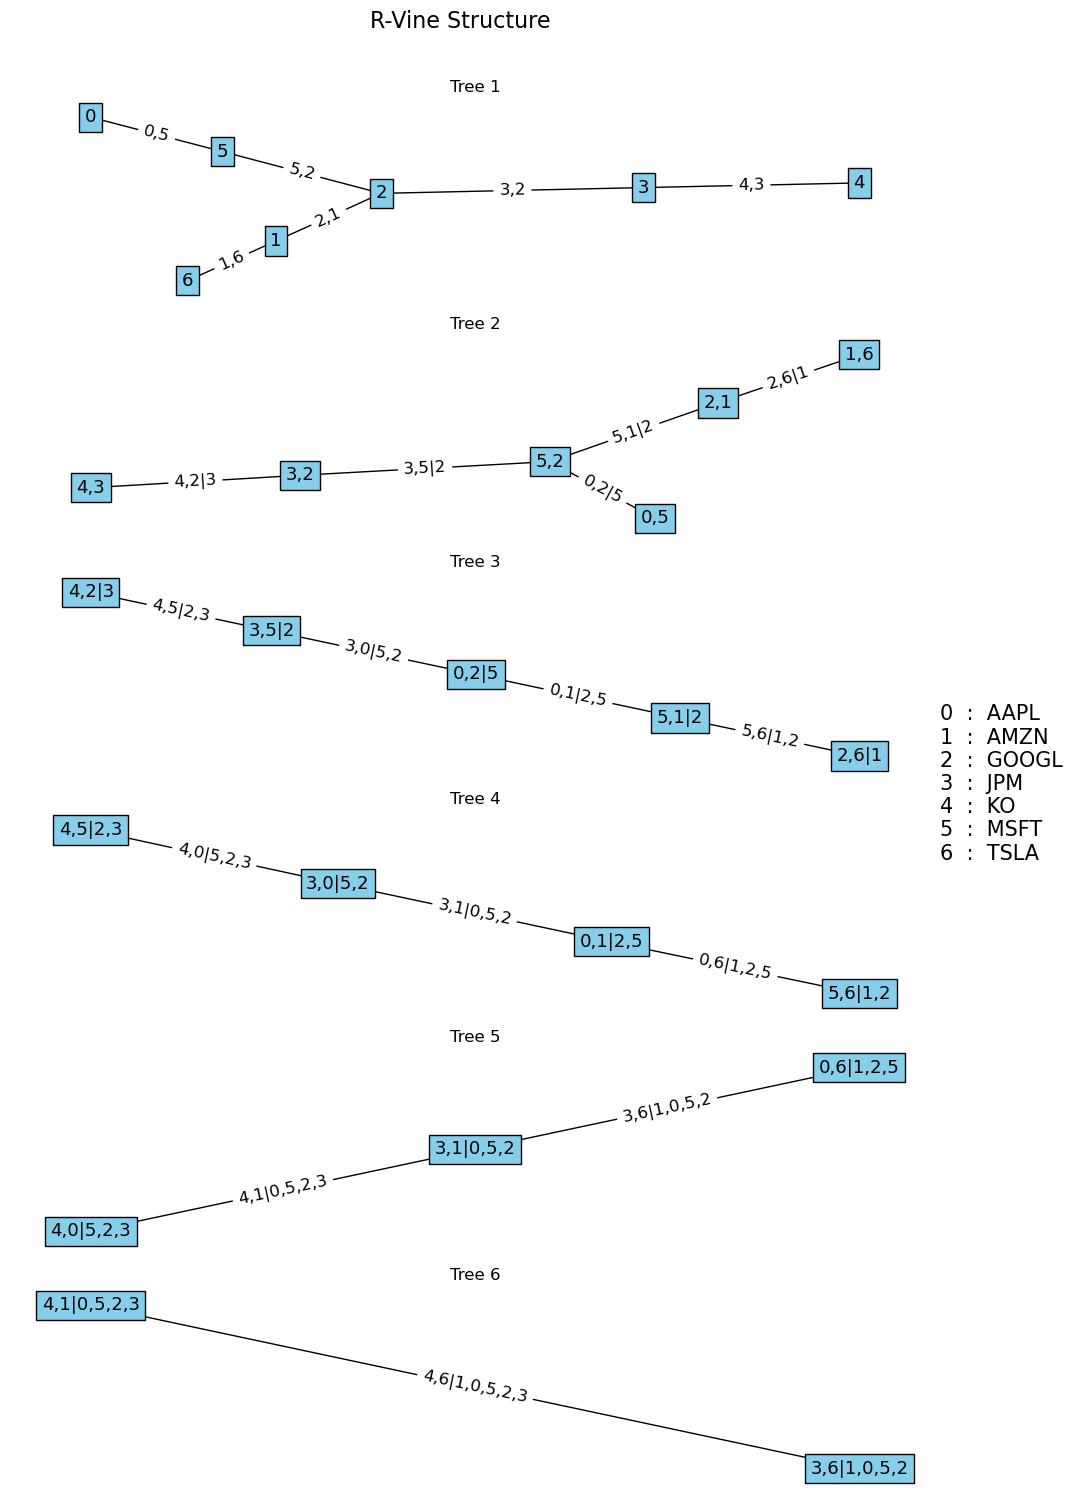

In [613]:
# To consider multiple copula families.
cops = list(range(1, 16))

M, P, C = fit_vinecop(pseudodata(data_pct_chg), cops, vine='R')  
plotvine(M, variables=list(data_pct_chg.columns), plottitle='R-Vine Structure')

n = 1000
simulations = pd.DataFrame(sample_vinecop(M, P, C, n), columns=data_pct_chg.columns)
simulated_observations_log_pct_change_vine_copula = pd.DataFrame(np.percentile(data_pct_chg, 100 * simulations))
simulated_observations_log_pct_change_vine_copula. columns = data_pct_chg.columns
actual_obs_simulated_vine_copula = np.exp(simulated_observations_log_pct_change_vine_copula).cumprod()

It is possible to derive the equivalent of the previous set of graphs in which the dependence structure is no more gaussian but simulated based on the R-vine structure fit.

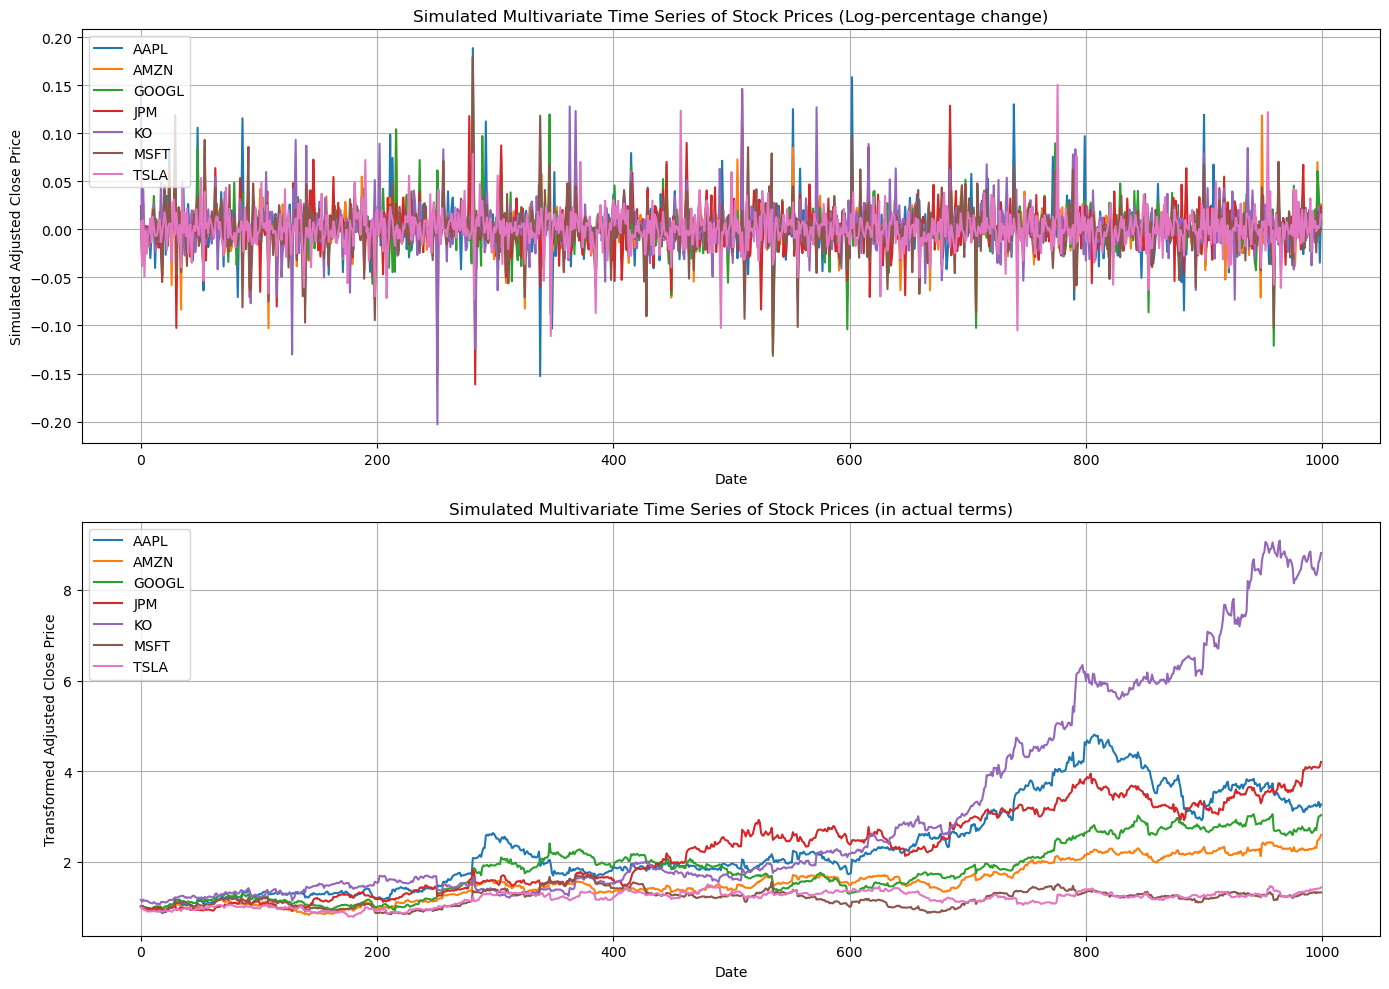

In [621]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
for ticker in simulated_observations_log_pct_change_vine_copula.columns:
    plt.plot(simulated_observations_log_pct_change_vine_copula.index, simulated_observations_log_pct_change_vine_copula[ticker], label=ticker)
plt.title('Simulated Multivariate Time Series of Stock Prices (Log-percentage change)')
plt.xlabel('Date')
plt.ylabel('Simulated Adjusted Close Price')
plt.legend(loc="upper left")
plt.grid(True)

plt.subplot(2, 1, 2)
for ticker in actual_obs_simulated_vine_copula.columns:
    plt.plot(actual_obs_simulated_vine_copula.index, actual_obs_simulated_vine_copula[ticker], label=ticker)
plt.title('Simulated Multivariate Time Series of Stock Prices (in actual terms)')
plt.xlabel('Date')
plt.ylabel('Transformed Adjusted Close Price')
plt.legend(loc="upper left")
plt.grid(True)

plt.tight_layout()
plt.show()

## Practical application
Copula modeling is common in a risk management framework in which the marginal time series are likely to have a distribution with a parametric structure different from the normal or the t-student. The following chunks propose a copula-based model to compute the VaR of the portfolio of stocks previously explored. This is implemented through the following steps:
1) out of the entire dataframe, the last 1.000 observations are considered as older observations are considered to be no more representative of the actual time series.
2) Through stationary bootstrapping, a multivariate time series of observations is simulated. In this case, the block lenght of each univariate time series is optimally determined as in "Automatic Block-Length Selection for the Dependent Bootstrap" (Dimitris N. Politis & Halbert White).
3) The desired amount of simulations is extracted form the vine-copula fit and, based on the percentiles estimated, the bootstrapped observations are reshuffled to mimic the dependence structure captured by the copula modelling. While the bootstrapped time series is greater, the compula samples will be of 250 observations, commonly considered as a business year. 
4) Based on the simulation it is possible to compute the overall percentage loss of the initial portfolio.
5) The steps 2,3 and 4 are iterated for the desired amount of simulations.

In [466]:
def add_group_elements_sb(initial_list, extraction, block):
    # The block might be non-integer. In this case, a binary random variable 0-1 is summed to the integer part of "block"
    # with a probability proportional to the fractional part.
    actual_block = math.floor(block) + np.random.binomial(n=1, p=(block - math.floor(block)))
    Initialize_list = [initial_list[extraction]]

    for i in range(1, actual_block):
        if (extraction + i) < len(initial_list):
            Initialize_list.append(initial_list[extraction + i])
        else:
            break

    return Initialize_list

def stationary_bootstrap(data_list, num_samples, block_size):  
    bootstrap_sample = []
    
    # Keep adding blocks until the sample is big enough
    while len(bootstrap_sample) < num_samples:
        extraction = np.random.randint(0, len(data_list))
        bootstrap_sample.extend(add_group_elements_sb(initial_list=data_list, 
                                                      extraction=extraction, 
                                                      block=block_size))
    return bootstrap_sample[:num_samples]

def stationary_bootstrap_for_df(df, n_sample):
    initialize_df = pd.DataFrame(np.ones((n_sample, df.shape[1],)))
    initialize_df.columns = df.columns
    for i in df.columns.tolist():
        temp_obs = stationary_bootstrap(data_list = df[i].tolist(), 
                                                num_samples = n_sample, 
                                                block_size = arch.bootstrap.optimal_block_length(df[i]).iloc[0,0])
        initialize_df[i] = temp_obs[:n_sample]
    return initialize_df

def VAR(df, n_days, simulations, days_for_stationary_bootstrap):
    initialize_percentage_returns = []
    df_pct_log = np.log(df.pct_change() + 1).iloc[1:]

    # Fit copula based on dataframe
    u = pseudodata(df_pct_log)
    cops = list(range(1, 16))
    M, P, C = fit_vinecop(u, cops, vine='C')

    for _ in range(simulations):
        observations_extracted = stationary_bootstrap_for_df(df_pct_log, days_for_stationary_bootstrap)
        copula_extractions = pd.DataFrame(sample_vinecop(M, P, C, n), columns=data_pct_chg.columns)
        shuffled_observations = pd.DataFrame(np.percentile(observations_extracted, 100 * copula_extractions))
        actual_observations = np.exp(shuffled_observations).cumprod()
        percentage_return = (actual_observations.loc[n_days - 1] / actual_observations.loc[0]).mean()
        initialize_percentage_returns.append(percentage_return)

    return initialize_percentage_returns

** Tree:  1
2,5  --->  Student : parameters =  [0.7572922768327727, 3.8779194027261576]
4,5  --->  Student : parameters =  [0.2979546349396337, 6.020598985315885]
3,5  --->  Student : parameters =  [0.2831546191381882, 6.120646285069618]
1,5  --->  Student : parameters =  [0.7187865827301675, 5.202839143740067]
0,5  --->  Student : parameters =  [0.7129639409658288, 5.191547620487347]
5,6  --->  Frank : parameters =  2.964294288100651
** Tree:  2
2,0|5  --->  Frank : parameters =  1.6719489444912135
4,0|5  --->  Frank : parameters =  0.8788782695727487
3,0|5  --->  Frank : parameters =  1.0832527746216973
1,0|5  --->  Student : parameters =  [0.2849250748118896, 8.192725970705371]
0,6|5  --->  Gaussian : parameters =  0.3091060633325497
** Tree:  3
2,1|0,5  --->  Student : parameters =  [0.2945035266420016, 29.451781585965545]
4,1|0,5  --->  Gaussian : parameters =  -0.0814751937532709
3,1|0,5  --->  Frank : parameters =  0.5342643915066896
1,6|0,5  --->  Frank : parameters =  1.116264

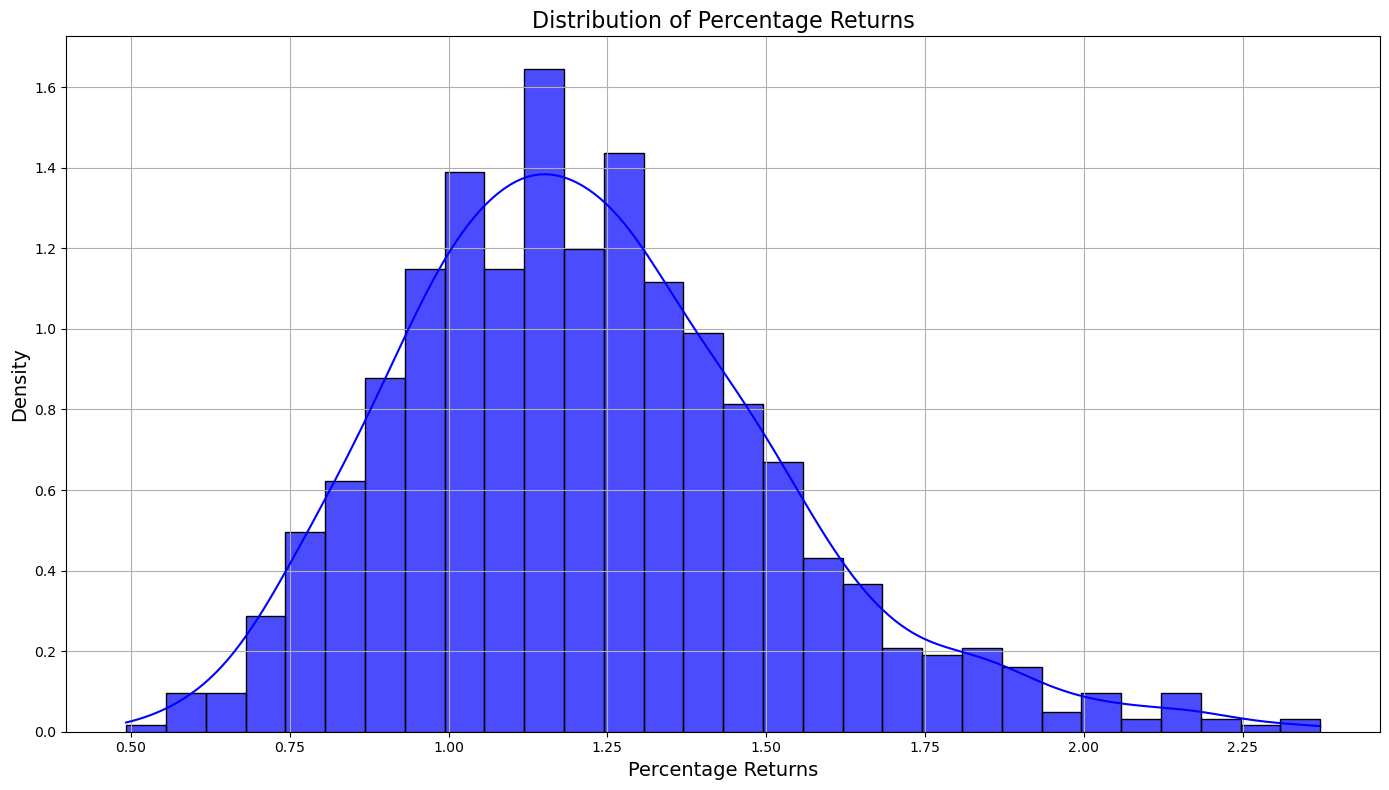

,VaRs of interest,VaR value
0,90.0,0.867490
1,95.0,0.793011
2,99.0,0.679655
3,99.9,0.564452


In [564]:
simulated_percentage_returns = VAR(data.tail(1000), # For better representativeness only the last 1000 days are sampled.
                                   n_days = 250, # Since the business year comprehends usually 250 days.
                                   simulations = 10000,
                                   days_for_stationary_bootstrap = 1000 # More than 250 are bootstrapped as they will determine more precise quantiles.
                                  )

# Plot the returns simulated
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.histplot(test_1, bins=30, kde=True, color='blue', stat='density', edgecolor='black', alpha=0.7, ax=ax)
ax.set_title('Distribution of Percentage Returns', fontsize=16)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlabel('Percentage Returns', fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()

pd.DataFrame(data = {'VaRs of interest': [90, 95, 99, 99.9], 'VaR value': [np.percentile(simulated_percentage_returns, q = 10),
                                                                           np.percentile(simulated_percentage_returns, q = 5),
                                                                           np.percentile(simulated_percentage_returns, q = 1),
                                                                           np.percentile(simulated_percentage_returns, q = .1)]})